In [1]:
import pickle, pdb, os, random
from model_bl import D_VECTOR
from collections import OrderedDict
import numpy as np
import torch

# C is the speaker encoder. The config values match with the paper
C = D_VECTOR(dim_input=80, dim_cell=768, dim_emb=256).eval().cuda()
# Speaker encoder checkpoint things. Load up the pretrained checkpoint info
c_checkpoint = torch.load('/homes/bdoc3/my_data/autovc_data/3000000-BL.ckpt')
new_state_dict = OrderedDict()
for key, val in c_checkpoint['model_b'].items():
    new_key = key[7:]
    new_state_dict[new_key] = val 
C.load_state_dict(new_state_dict)
num_uttrs = 10
len_crop = 192 
singer_names = ['m1_','m2_','m3_','m4_','m5_','m6_','m7_','m8_','m9_','m10_','m11_','f1_','f2_','f3_','f4_','f5_','f6_','f7_','f8_','f9_']
# Directory containing mel-spectrograms
rootDir = '/homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized'
dirName, subdirList, fileList = next(os.walk(rootDir))
print('Found directory: %s' % dirName)

# speakers contains list of utterance paths/embeddings
speakers = []
# each speaker is a folder path to that speaker
list_of_embs = [[] for i in range(len(singer_names))]
avg_embs = []
for s_idx in range(len(singer_names)):
    single_singer_file_list = [i for i in fileList if i.startswith(singer_names[s_idx])] 
    for file_name in sorted(single_singer_file_list):
        print('Processing: %s' % file_name)
        tmp = np.load(os.path.join(dirName, file_name))
        if tmp.shape[0] < len_crop:
            continue
        centered_spmel = tmp[np.newaxis, (tmp.shape[0]//2)-(len_crop//2):(tmp.shape[0]//2)+(len_crop//2)]
        melsp = torch.from_numpy(centered_spmel).cuda()
        # put mels through the speaker encoder to get their embeddings
        # pdb.set_trace()
        emb = C(melsp)
        list_of_embs[s_idx].append(emb.detach().squeeze().cpu().numpy())    
    # Get mean of embs across rows, and add this to utterances list
    avg_embs.append((singer_names[s_idx], np.mean(list_of_embs[s_idx], axis=0)))

Found directory: /homes/bdoc3/my_data/phonDet/spmel_autovc_params_unnormalized
Processing: m1_arpeggios_belt_a.npy
Processing: m1_arpeggios_belt_e.npy
Processing: m1_arpeggios_belt_i.npy
Processing: m1_arpeggios_belt_o.npy
Processing: m1_arpeggios_belt_u.npy
Processing: m1_arpeggios_breathy_a.npy
Processing: m1_arpeggios_breathy_e.npy
Processing: m1_arpeggios_breathy_i.npy
Processing: m1_arpeggios_breathy_o.npy
Processing: m1_arpeggios_breathy_u.npy
Processing: m1_arpeggios_lip_trill_a.npy
Processing: m1_arpeggios_lip_trill_e.npy
Processing: m1_arpeggios_lip_trill_i.npy
Processing: m1_arpeggios_lip_trill_o.npy
Processing: m1_arpeggios_lip_trill_u.npy
Processing: m1_arpeggios_straight_a.npy
Processing: m1_arpeggios_straight_e.npy
Processing: m1_arpeggios_straight_i.npy
Processing: m1_arpeggios_straight_o.npy
Processing: m1_arpeggios_straight_u.npy
Processing: m1_arpeggios_vibrato_a.npy
Processing: m1_arpeggios_vibrato_e.npy
Processing: m1_arpeggios_vibrato_i.npy
Processing: m1_arpeggios

Processing: m4_scales_vibrato_u.npy
Processing: m4_scales_vocal_fry_a.npy
Processing: m4_scales_vocal_fry_e.npy
Processing: m4_scales_vocal_fry_i.npy
Processing: m4_scales_vocal_fry_o.npy
Processing: m4_scales_vocal_fry_u.npy
Processing: m5_arpeggios_belt_a.npy
Processing: m5_arpeggios_belt_e.npy
Processing: m5_arpeggios_belt_i.npy
Processing: m5_arpeggios_belt_o.npy
Processing: m5_arpeggios_belt_u.npy
Processing: m5_arpeggios_breathy_a.npy
Processing: m5_arpeggios_breathy_e.npy
Processing: m5_arpeggios_breathy_i.npy
Processing: m5_arpeggios_breathy_o.npy
Processing: m5_arpeggios_breathy_u.npy
Processing: m5_arpeggios_lip_trill_a.npy
Processing: m5_arpeggios_lip_trill_e.npy
Processing: m5_arpeggios_lip_trill_i.npy
Processing: m5_arpeggios_lip_trill_o.npy
Processing: m5_arpeggios_lip_trill_u.npy
Processing: m5_arpeggios_straight_a.npy
Processing: m5_arpeggios_straight_e.npy
Processing: m5_arpeggios_straight_i.npy
Processing: m5_arpeggios_straight_o.npy
Processing: m5_arpeggios_straight_

Processing: m8_scales_belt_a.npy
Processing: m8_scales_belt_e.npy
Processing: m8_scales_belt_i.npy
Processing: m8_scales_belt_o.npy
Processing: m8_scales_belt_u.npy
Processing: m8_scales_breathy_a.npy
Processing: m8_scales_breathy_e.npy
Processing: m8_scales_breathy_i.npy
Processing: m8_scales_breathy_o.npy
Processing: m8_scales_breathy_u.npy
Processing: m8_scales_lip_trill_a.npy
Processing: m8_scales_lip_trill_e.npy
Processing: m8_scales_lip_trill_i.npy
Processing: m8_scales_lip_trill_o.npy
Processing: m8_scales_lip_trill_u.npy
Processing: m8_scales_straight_a.npy
Processing: m8_scales_straight_e.npy
Processing: m8_scales_straight_i.npy
Processing: m8_scales_straight_o.npy
Processing: m8_scales_straight_u.npy
Processing: m8_scales_vibrato_a.npy
Processing: m8_scales_vibrato_e.npy
Processing: m8_scales_vibrato_i.npy
Processing: m8_scales_vibrato_o.npy
Processing: m8_scales_vibrato_u.npy
Processing: m8_scales_vocal_fry_a.npy
Processing: m8_scales_vocal_fry_e.npy
Processing: m8_scales_vo

Processing: f1_arpeggios_breathy_i.npy
Processing: f1_arpeggios_breathy_o.npy
Processing: f1_arpeggios_breathy_u.npy
Processing: f1_arpeggios_lip_trill_a.npy
Processing: f1_arpeggios_lip_trill_e.npy
Processing: f1_arpeggios_lip_trill_i.npy
Processing: f1_arpeggios_lip_trill_o.npy
Processing: f1_arpeggios_lip_trill_u.npy
Processing: f1_arpeggios_straight_a.npy
Processing: f1_arpeggios_straight_e.npy
Processing: f1_arpeggios_straight_i.npy
Processing: f1_arpeggios_straight_o.npy
Processing: f1_arpeggios_straight_u.npy
Processing: f1_arpeggios_vibrato_a.npy
Processing: f1_arpeggios_vibrato_e.npy
Processing: f1_arpeggios_vibrato_i.npy
Processing: f1_arpeggios_vibrato_o.npy
Processing: f1_arpeggios_vibrato_u.npy
Processing: f1_arpeggios_vocal_fry_a.npy
Processing: f1_arpeggios_vocal_fry_e.npy
Processing: f1_arpeggios_vocal_fry_i.npy
Processing: f1_arpeggios_vocal_fry_o.npy
Processing: f1_arpeggios_vocal_fry_u.npy
Processing: f1_scales_belt_a.npy
Processing: f1_scales_belt_e.npy
Processing: 

Processing: f4_scales_straight_a.npy
Processing: f4_scales_straight_e.npy
Processing: f4_scales_straight_i.npy
Processing: f4_scales_straight_o.npy
Processing: f4_scales_straight_u.npy
Processing: f4_scales_vibrato_a.npy
Processing: f4_scales_vibrato_e.npy
Processing: f4_scales_vibrato_i.npy
Processing: f4_scales_vibrato_o.npy
Processing: f4_scales_vibrato_u.npy
Processing: f4_scales_vocal_fry_a.npy
Processing: f4_scales_vocal_fry_e.npy
Processing: f4_scales_vocal_fry_i.npy
Processing: f4_scales_vocal_fry_o.npy
Processing: f4_scales_vocal_fry_u.npy
Processing: f5_arpeggios_belt_a.npy
Processing: f5_arpeggios_belt_e.npy
Processing: f5_arpeggios_belt_i.npy
Processing: f5_arpeggios_belt_o.npy
Processing: f5_arpeggios_belt_u.npy
Processing: f5_arpeggios_breathy_a.npy
Processing: f5_arpeggios_breathy_e.npy
Processing: f5_arpeggios_breathy_i.npy
Processing: f5_arpeggios_breathy_o.npy
Processing: f5_arpeggios_breathy_u.npy
Processing: f5_arpeggios_lip_trill_a.npy
Processing: f5_arpeggios_lip_

Processing: f8_arpeggios_vibrato_e.npy
Processing: f8_arpeggios_vibrato_i.npy
Processing: f8_arpeggios_vibrato_o.npy
Processing: f8_arpeggios_vibrato_u.npy
Processing: f8_arpeggios_vocal_fry_a.npy
Processing: f8_arpeggios_vocal_fry_e.npy
Processing: f8_arpeggios_vocal_fry_i.npy
Processing: f8_arpeggios_vocal_fry_o.npy
Processing: f8_arpeggios_vocal_fry_u.npy
Processing: f8_scales_belt_a.npy
Processing: f8_scales_belt_e.npy
Processing: f8_scales_belt_i.npy
Processing: f8_scales_belt_o.npy
Processing: f8_scales_belt_u.npy
Processing: f8_scales_breathy_a.npy
Processing: f8_scales_breathy_e.npy
Processing: f8_scales_breathy_i.npy
Processing: f8_scales_breathy_o.npy
Processing: f8_scales_breathy_u.npy
Processing: f8_scales_lip_trill_a.npy
Processing: f8_scales_lip_trill_e.npy
Processing: f8_scales_lip_trill_i.npy
Processing: f8_scales_lip_trill_o.npy
Processing: f8_scales_lip_trill_u.npy
Processing: f8_scales_straight_a.npy
Processing: f8_scales_straight_e.npy
Processing: f8_scales_straight

In [6]:
import math

def tensor_to_matrix(array):
    sqr = int(math.sqrt(array.shape[0]))
    embs_mat = array.reshape((sqr,sqr))
    return embs_mat

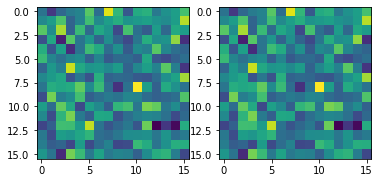

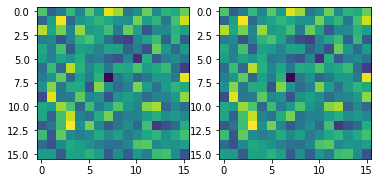

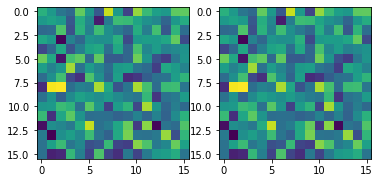

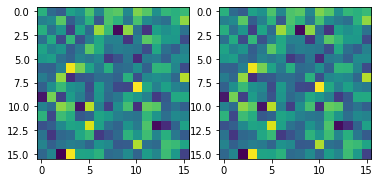

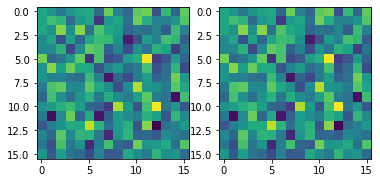

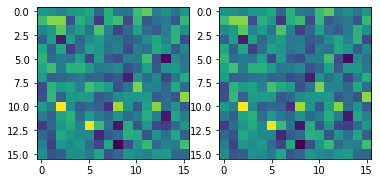

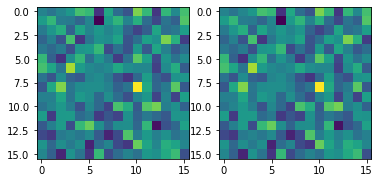

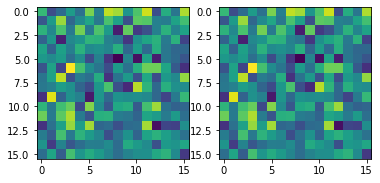

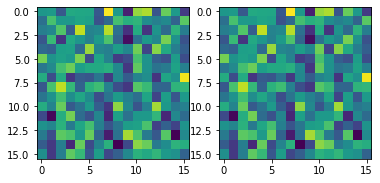

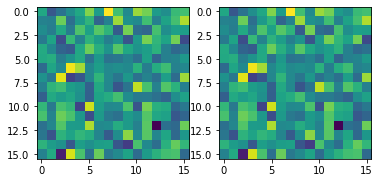

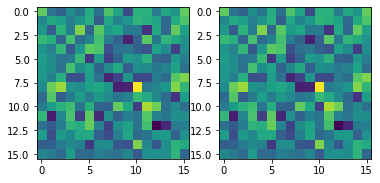

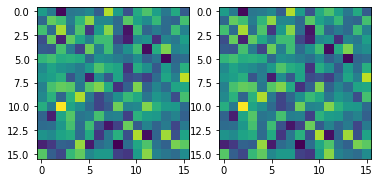

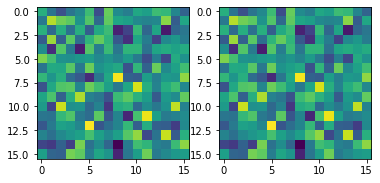

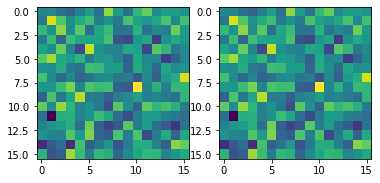

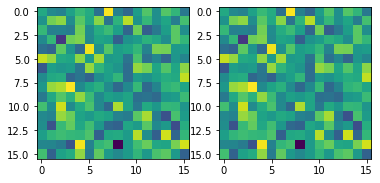

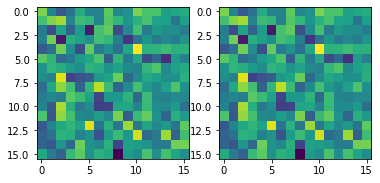

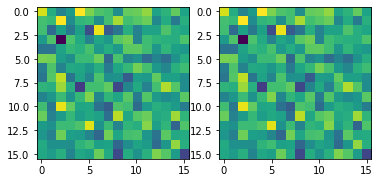

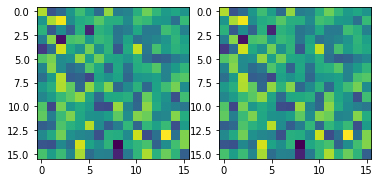

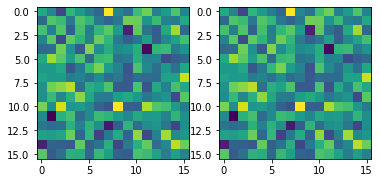

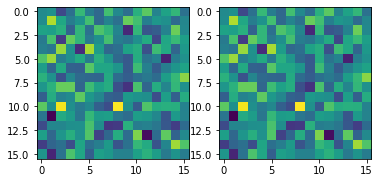

In [15]:
import matplotlib.pyplot as plt

avg_emb_arr=None
for i in range(len(list_of_embs)):
    avg_emb = np.mean(np.asarray(list_of_embs[i]), axis=0)
    try:
        avg_emb_arr = np.vstack((avg_emb_arr, avg_emb))
    except:
        avg_emb_arr = avg_emb

for i in range(len(avg_emb_arr)):
    sqr_avg_emb = tensor_to_matrix(avg_emb_arr[i])
    other_sqr_avg_emb = tensor_to_matrix(avg_embs[i][1])
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(sqr_avg_emb)
    plt.subplot(1,2,2)
    plt.imshow(other_sqr_avg_emb)

In [11]:
len(avg_emb_arr), len(avg_embs), len(list_of_embs)

(20, 20, 20)

In [16]:
from sklearn.cluster import KMeans

def sse_view(array, k_max):
    # set up k_means clustering
    k_range = range(1, k_max)
    sum_squared_error = []
    for k_dim in k_range:    
        km = KMeans(n_clusters=k_dim)
        km.fit_predict(flattened_embs_arr)
    #    print(km.cluster_centers_.shape, km.cluster_centers_) 
        sum_squared_error.append(km.inertia_)
    plt.plot(k_range, sum_squared_error)

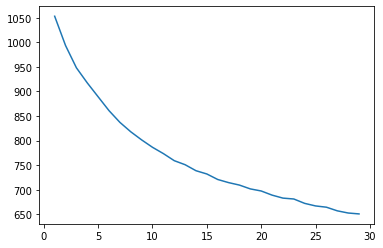

In [18]:
flattened_embs_arr = np.asarray([item for sublist in list_of_embs for item in sublist])
sse_view(flattened_embs_arr, 30)

In [17]:
with open('./singer_id_embs.pkl', 'wb') as handle:
    pickle.dump(avg_embs, handle)